In [1]:
import os

import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt

from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

In [2]:
device0 = torch.device("cuda:0")
device1 = torch.device("cuda:1")

# use bfloat16 for the entire notebook
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
# turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [3]:
np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

In [8]:
sam2_checkpoint = "../models/SAM2/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device0, apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(sam2)

mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=25.0,
    use_m2m=True,
)

In [5]:
# Read the input image and convert to tensor (3, H, W) with RGB values normalized to [0, 1]
input_image = cv2.cvtColor(cv2.imread("../data/sample_images/image.png"), cv2.COLOR_BGR2RGB)                       
input_image_tensor = torch.tensor(input_image / 255, dtype=torch.float32, device=device0).permute(2, 0, 1)    
input_image_array  = np.array(input_image)

In [13]:
masks = mask_generator_2.generate(input_image_array)

/home/christopher/Documents/Code/segment-anything-2/sam2/sam2_image_predictor.py:431: UserWarning: cannot import name '_C' from 'sam2' (/home/christopher/Documents/Code/segment-anything-2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  masks = self._transforms.postprocess_masks(


In [21]:
import pickle
with open('masks.pkl', 'wb') as f:  # open a text file
    pickle.dump(masks, f) # serialize the list

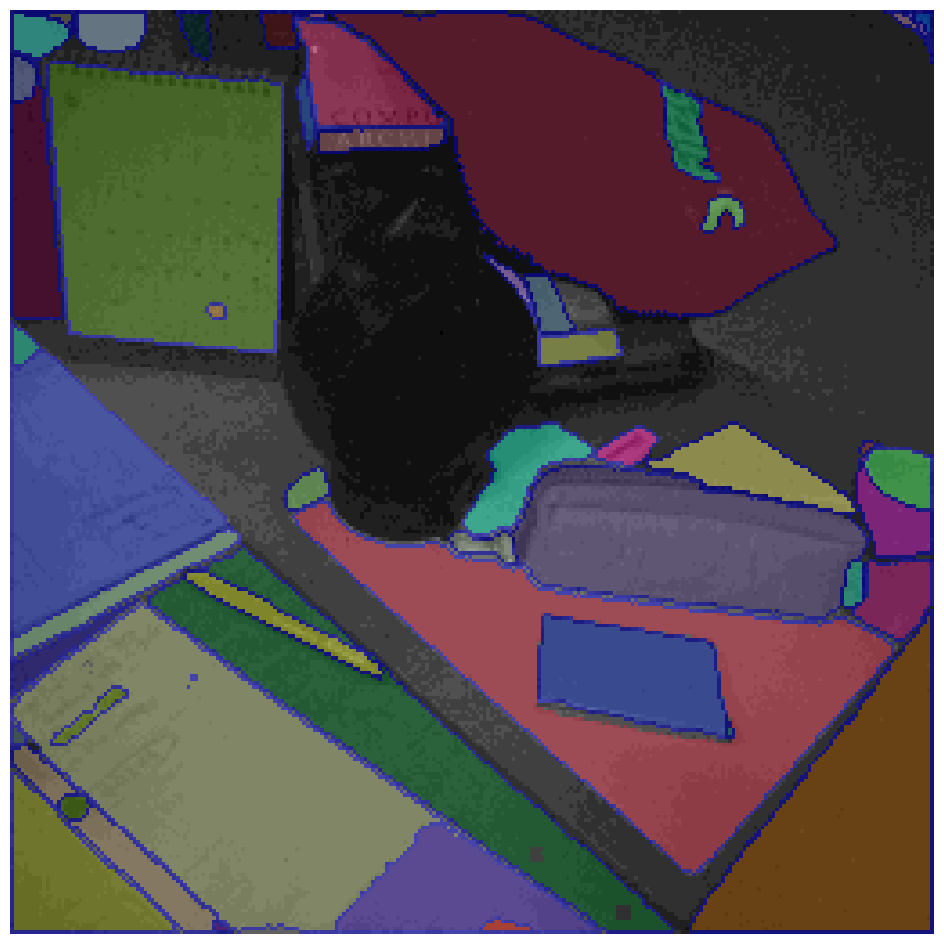

In [14]:
plt.figure(figsize=(12,12))
plt.imshow(input_image_array)
show_anns(masks)
plt.axis('off')
plt.show() 